In [1]:
import numpy as np
import pandas as pd
import emoji
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

In [2]:
df = pd.read_csv("mediacloud-AI.csv")
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url
0,19d73b7cd0a23f961ea3aae6d1554c62b004aac1a4a6c7...,2025-12-24 05:22:29.307373+00:00,en,sandiegouniontribune.com,sandiegouniontribune.com,2025-12-23,UC San Diego eyes campuswide AI coordinating s...,https://www.sandiegouniontribune.com/2025/12/2...
1,8ea4c1650576763e5fe3471911fbdbacaf7edafc3ab052...,2025-12-24 05:20:33.347048+00:00,en,townhall.com,townhall.com,2025-12-23,President Trump Takes a Victory Lap Over Fanta...,https://townhall.com/tipsheet/amy-curtis/2025/...
2,fbebfda1017f09254d799296d2d28dc6d4306b68c432b6...,2025-12-24 04:25:36.871520+00:00,en,dailycaller.com,dailycaller.com,2025-12-23,Kevin Hassett Assesses New Numbers And Explain...,https://dailycaller.com/2025/12/23/kevin-hasse...
3,5dc81d658b56b2424da775f9d2496810172b4e7e907305...,2025-12-24 03:21:38.495827+00:00,en,theweek.com,theweek.com,2025-12-23,Trump vs. states: Who gets to regulate AI?,https://theweek.com/politics/trump-states-regu...
4,8c34961a3af69294198033d38a21cca091baf4c89907ab...,2025-12-24 03:21:19.174848+00:00,en,theweek.com,theweek.com,2025-12-23,Tariffs have American whiskey distillers on th...,https://theweek.com/business/economy-whiskey-t...


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 21265 entries, 0 to 21264
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            21265 non-null  str  
 1   indexed_date  21265 non-null  str  
 2   language      21265 non-null  str  
 3   media_name    21265 non-null  str  
 4   media_url     21265 non-null  str  
 5   publish_date  21265 non-null  str  
 6   title         21265 non-null  str  
 7   url           21265 non-null  str  
dtypes: str(8)
memory usage: 1.3 MB


In [4]:
keywords = ["ai","a.i.","artificial intelligence","deepfake!","deep fake!","chatgpt","chat GPT","chatbot!","language model!","machine learning"]
pattern = r'\b(?:' + '|'.join(keywords) + r')\b'
ai_df = df[df['title'].str.contains(pattern,case=False,na=False)]
ai_df.shape

(8999, 8)

In [5]:
ai_df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url
0,19d73b7cd0a23f961ea3aae6d1554c62b004aac1a4a6c7...,2025-12-24 05:22:29.307373+00:00,en,sandiegouniontribune.com,sandiegouniontribune.com,2025-12-23,UC San Diego eyes campuswide AI coordinating s...,https://www.sandiegouniontribune.com/2025/12/2...
3,5dc81d658b56b2424da775f9d2496810172b4e7e907305...,2025-12-24 03:21:38.495827+00:00,en,theweek.com,theweek.com,2025-12-23,Trump vs. states: Who gets to regulate AI?,https://theweek.com/politics/trump-states-regu...
6,8424d86c8fb3e91c1ba6ac73b2a9c92fae17bf36871802...,2025-12-24 00:29:59.301749+00:00,en,benzinga.com,benzinga.com,2025-12-23,AI Pioneer Yoshua Bengio Reveals He Misleads C...,https://www.benzinga.com/markets/tech/25/12/49...
8,ee34202162eff5335539b80f463a1b20b5f73173155656...,2025-12-24 00:22:34.618199+00:00,en,benzinga.com,benzinga.com,2025-12-23,From Discoverative AI to the Entropy of Tolera...,https://www.benzinga.com/pressreleases/25/12/n...
11,df68b6f39f396d32a2f81a00f381bc30eeb07f72186d82...,2025-12-24 00:19:46.702100+00:00,en,ign.com,ign.com,2025-12-23,"Eddy Burback Made The First Great Horror ""Movi...",https://www.ign.com/videos/eddy-burback-made-t...


In [6]:
articles_df = pd.read_json('articles.jsonl', lines=True)
articles_df.shape

(7510, 7)

In [7]:
articles_df.head(1)

,url,error,title,text,top_image,images,num_images
0,https://theconversation.com/how-can-canada-bec...,NaN,How can Canada become a global AI powerhouse? ...,Artificial intelligence is everywhere. In fact...,https://images.theconversation.com/files/70923...,[https://images.theconversation.com/files/7092...,7


In [8]:
articles_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7510 entries, 0 to 7509
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   url         7510 non-null   str    
 1   error       0 non-null      float64
 2   title       7510 non-null   str    
 3   text        7510 non-null   str    
 4   top_image   7510 non-null   str    
 5   images      7510 non-null   object 
 6   num_images  7510 non-null   int64  
dtypes: float64(1), int64(1), object(1), str(4)
memory usage: 410.8+ KB


In [9]:
def text_cleaning(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+', '', text)
  text = re.sub(r'<.*?>', '', text)
  text = emoji.replace_emoji(text, replace='')
  text = re.sub(r"[^a-z\s']", ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [10]:
articles_df['cleaned_text'] = articles_df['text'].apply(text_cleaning)

In [11]:
texts = articles_df['cleaned_text'].astype(str).to_list()

In [12]:
em_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = em_model.encode(texts, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

In [13]:
import umap

In [14]:
um_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

In [15]:
import hdbscan

In [16]:
hs_model = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

In [17]:
vectorizer_model = CountVectorizer(stop_words="english")

In [18]:
from bertopic import BERTopic

In [19]:
tc_model = BERTopic(
    embedding_model=em_model,
    umap_model=um_model,
    hdbscan_model=hs_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

In [20]:
topics, probabs = tc_model.fit_transform(texts, embeddings)

2026-02-06 13:06:45,204 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-06 13:06:57,775 - BERTopic - Dimensionality - Completed ✓
2026-02-06 13:06:57,775 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-06 13:06:59,705 - BERTopic - Cluster - Completed ✓
2026-02-06 13:06:59,709 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-06 13:07:00,771 - BERTopic - Representation - Completed ✓


In [21]:
topic_info = tc_model.get_topic_info()
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2645,-1_ai_said_data_like,"[ai, said, data, like, people, new, company, u...",[three years ago today openai unassumingly rel...
1,0,239,0_students_teachers_education_school,"[students, teachers, education, school, studen...",[chase joined mashable's social good team in c...
2,1,212,1_energy_power_centers_center,"[energy, power, centers, center, data, electri...",[data centers are springing up across tropical...
3,2,142,2_leaders_business_ai_teams,"[leaders, business, ai, teams, value, leadersh...",[ross wainwright is ceo of perceptyx the ai co...
4,3,132,3_music_artists_song_songs,"[music, artists, song, songs, spotify, suno, u...",[spotify has announced it is teaming up with t...


In [22]:
topic_info.shape

(123, 5)

In [23]:
tc_model.visualize_barchart()

In [24]:
tc_model.visualize_topics()

In [25]:
tc_model.visualize_hierarchy()

## Model 2 - tuning umap and hdbscan

In [36]:
new_umap = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.3,
    metric='cosine',
    random_state=42
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=10,
    metric="euclidean"
)

tc_model = BERTopic(
    hdbscan_model=hdbscan_model,
    umap_model=new_umap
)

new_topics, new_probs = tc_model.fit_transform(texts)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [37]:
new_topic_info = tc_model.get_topic_info()
new_topic_info.shape

(139, 5)

In [38]:
tc_model.visualize_barchart()

In [39]:
tc_model.visualize_topics()

## Merging topics

In [26]:
hierarchical_topics = tc_model.hierarchical_topics(texts)
hierarchical_topics.shape

100%|██████████| 121/121 [00:00<00:00, 756.23it/s]


(121, 8)

In [27]:
hierarchical_topics.head()

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
120,242,ai_said_chatgpt_new_openai,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",239,ai_data_said_intelligence_technology,241,chatgpt_openai_ai_users_said,1.940242
119,241,chatgpt_openai_ai_users_said,"[3, 4, 7, 9, 12, 13, 16, 19, 21, 22, 24, 25, 2...",240,said_mental_music_ai_openai,236,chatgpt_openai_google_browser_apple,1.689099
118,240,said_mental_music_ai_openai,"[3, 7, 12, 13, 16, 19, 21, 24, 25, 28, 29, 32,...",219,mental_health_parents_therapist_children,235,music_generated_video_disney_said,1.515987
117,239,ai_data_said_intelligence_technology,"[0, 1, 2, 5, 6, 8, 10, 11, 14, 15, 17, 18, 20,...",229,nvidia_chips_china_billion_bubble,238,ai_data_said_new_students,1.470043
116,238,ai_data_said_new_students,"[0, 1, 2, 6, 8, 10, 11, 15, 17, 18, 20, 23, 26...",237,ai_data_said_students_new,166,state_laws_states_order_federal,1.432454


In [28]:
hierarchical_topics['Distance'].describe()

count    121.000000
mean       0.807091
std        0.284807
min        0.339746
25%        0.619103
50%        0.771632
75%        0.953963
max        1.940242
Name: Distance, dtype: float64

In [29]:
hierarchical_topics.sort_values("Distance").head(10)

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
0,122,state_order_laws_states_federal,"[15, 96]",96,federal_cruz_state_states_preemption,15,order_state_laws_states_trump,0.339746
1,123,shopping_shoppers_retailers_holiday_product,"[9, 108]",108,shopping_chatgpt_research_target_deals,9,shopping_shoppers_holiday_retailers_retail,0.350895
2,124,leaders_ai_teams_business_value,"[2, 46]",2,leaders_business_ai_teams_value,46,manufacturing_genai_systems_agentic_mes,0.371976
3,125,meta_llama_zuckerberg_wang_superintelligence,"[76, 118]",118,llama_meta_zuckerberg_tbd_models,76,meta_wang_superintelligence_zuckerberg_employees,0.375628
4,126,job_skills_jobs_workers_roles,"[17, 18]",18,jobs_workers_job_labor_automation,17,skills_job_resume_roles_career,0.391686
5,127,openai_chatgpt_gpt_users_altman,"[72, 86]",72,altman_openai_google_red_memo,86,openai_chatgpt_gpt_users_model,0.395098
6,128,chatbots_teens_character_children_parents,"[7, 53]",7,character_chatbots_teens_age_children,53,meta_parents_teens_chatbots_characters,0.410401
7,129,sora_videos_video_app_openai,"[45, 61]",61,sora_videos_video_king_openai,45,sora_videos_app_video_vibes,0.427112
8,130,ai_organizations_leaders_teams_data,"[2, 10, 46]",10,security_cybersecurity_organizations_risk_gove...,124,leaders_ai_teams_business_value,0.439061
9,131,chips_china_nvidia_huang_trump,"[36, 121]",121,huang_chips_china_nvidia_meeting,36,china_chips_nvidia_chip_trump,0.444253


In [30]:
merges = hierarchical_topics[hierarchical_topics["Distance"] <= 0.95]

In [31]:
merge_topics = merges["Topics"].tolist()

In [32]:
tc_model.merge_topics(texts, merge_topics)

In [33]:
tc_model.visualize_barchart()

In [34]:
new_topics = tc_model.get_topic_info()
new_topics.shape

(48, 5)

In [35]:
new_topics.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2645,-1_ai_said_data_like,"[ai, said, data, like, new, people, company, u...",[three years ago today openai unassumingly rel...
1,0,312,0_students_teachers_education_ai,"[students, teachers, education, ai, school, le...",[a few months ago a high school english teache...
2,1,275,1_ai_data_organizations_leaders,"[ai, data, organizations, leaders, business, t...",[getty artificial intelligence is helping comp...
3,2,257,2_nvidia_billion_bubble_ai,"[nvidia, billion, bubble, ai, company, market,...",[by michael liedtke san francisco ap nvidia s ...
4,3,250,3_energy_data_power_centers,"[energy, data, power, centers, center, electri...",[fueled by a boom in artificial intelligence a...


In [36]:
len(tc_model.topics_)

7510

In [37]:
articles_df['TopicId'] = tc_model.topics_

In [38]:
articles_df.head()

,url,error,title,text,top_image,images,num_images,cleaned_text,TopicId
0,https://theconversation.com/how-can-canada-bec...,NaN,How can Canada become a global AI powerhouse? ...,Artificial intelligence is everywhere. In fact...,https://images.theconversation.com/files/70923...,[https://images.theconversation.com/files/7092...,7,artificial intelligence is everywhere in fact ...,3
1,https://www.ign.com/videos/eddy-burback-made-t...,NaN,"Eddy Burback Made The First Great Horror ""Movi...",0:23\n\n28 Years Later Star Wants to Be in a D...,https://assets-prd.ignimgs.com/2025/12/20/eddy...,[https://assets-prd.ignimgs.com/2025/12/20/edd...,2,years later star wants to be in a dead space m...,-1
2,https://www.cnbc.com/2025/12/23/ais-machine-le...,NaN,Here's how AI could influence the Fed's econom...,Members of the Federal Reserve rate-setting co...,https://image.cnbcfm.com/api/v1/image/10815044...,[https://image.cnbcfm.com/api/v1/image/1081504...,10,members of the federal reserve rate setting co...,5
3,https://www.cnbc.com/2025/12/23/ai-cost-effici...,NaN,The next AI pivot will be toward efficiency an...,"Kelly, who was also general counsel at Faceboo...",https://image.cnbcfm.com/api/v1/image/10817571...,[https://static-redesign.cnbcfm.com/dist/69ae0...,9,kelly who was also general counsel at facebook...,3
4,https://www.ajc.com/opinion/2025/12/how-savann...,NaN,"How Savannah is building a stronger, smarter t...",Savannah Mayor Van Johnson — pictured speaking...,https://images.ajc.com/resizer/v2/JYILCLLNUVAQ...,[https://www.ajc.com/resources/logos/AJC/ajc-l...,7,savannah mayor van johnson pictured speaking a...,3


In [39]:
articles_df['TopicId'].unique().shape

(48,)

In [40]:
label_dict = dict(zip(new_topics['Topic'], new_topics['Name']))

In [41]:
articles_df['Topic_name'] = articles_df['TopicId'].map(label_dict)

In [42]:
articles_df.head()

,url,error,title,text,top_image,images,num_images,cleaned_text,TopicId,Topic_name
0,https://theconversation.com/how-can-canada-bec...,NaN,How can Canada become a global AI powerhouse? ...,Artificial intelligence is everywhere. In fact...,https://images.theconversation.com/files/70923...,[https://images.theconversation.com/files/7092...,7,artificial intelligence is everywhere in fact ...,3,3_energy_data_power_centers
1,https://www.ign.com/videos/eddy-burback-made-t...,NaN,"Eddy Burback Made The First Great Horror ""Movi...",0:23\n\n28 Years Later Star Wants to Be in a D...,https://assets-prd.ignimgs.com/2025/12/20/eddy...,[https://assets-prd.ignimgs.com/2025/12/20/edd...,2,years later star wants to be in a dead space m...,-1,-1_ai_said_data_like
2,https://www.cnbc.com/2025/12/23/ais-machine-le...,NaN,Here's how AI could influence the Fed's econom...,Members of the Federal Reserve rate-setting co...,https://image.cnbcfm.com/api/v1/image/10815044...,[https://image.cnbcfm.com/api/v1/image/1081504...,10,members of the federal reserve rate setting co...,5,5_job_jobs_skills_ai
3,https://www.cnbc.com/2025/12/23/ai-cost-effici...,NaN,The next AI pivot will be toward efficiency an...,"Kelly, who was also general counsel at Faceboo...",https://image.cnbcfm.com/api/v1/image/10817571...,[https://static-redesign.cnbcfm.com/dist/69ae0...,9,kelly who was also general counsel at facebook...,3,3_energy_data_power_centers
4,https://www.ajc.com/opinion/2025/12/how-savann...,NaN,"How Savannah is building a stronger, smarter t...",Savannah Mayor Van Johnson — pictured speaking...,https://images.ajc.com/resizer/v2/JYILCLLNUVAQ...,[https://www.ajc.com/resources/logos/AJC/ajc-l...,7,savannah mayor van johnson pictured speaking a...,3,3_energy_data_power_centers


In [43]:
merged_df = ai_df.merge(articles_df, on='url', how='left')

In [44]:
merged_df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title_x,url,error,title_y,text,top_image,images,num_images,cleaned_text,TopicId,Topic_name
0,19d73b7cd0a23f961ea3aae6d1554c62b004aac1a4a6c7...,2025-12-24 05:22:29.307373+00:00,en,sandiegouniontribune.com,sandiegouniontribune.com,2025-12-23,UC San Diego eyes campuswide AI coordinating s...,https://www.sandiegouniontribune.com/2025/12/2...,NaN,UC San Diego eyes campuswide AI coordinating s...,As institutions across the world establish app...,https://www.sandiegouniontribune.com/wp-conten...,[https://www.sandiegouniontribune.com/wp-conte...,6.0,as institutions across the world establish app...,-1.0,-1_ai_said_data_like
1,5dc81d658b56b2424da775f9d2496810172b4e7e907305...,2025-12-24 03:21:38.495827+00:00,en,theweek.com,theweek.com,2025-12-23,Trump vs. states: Who gets to regulate AI?,https://theweek.com/politics/trump-states-regu...,NaN,Trump vs. states: Who gets to regulate AI?,Should technology that’s going to determine Am...,https://cdn.mos.cms.futurecdn.net/FhdL3tZb3YpM...,[https://cdn.mos.cms.futurecdn.net/STkhkAgPdNM...,18.0,should technology that s going to determine am...,-1.0,-1_ai_said_data_like
2,8424d86c8fb3e91c1ba6ac73b2a9c92fae17bf36871802...,2025-12-24 00:29:59.301749+00:00,en,benzinga.com,benzinga.com,2025-12-23,AI Pioneer Yoshua Bengio Reveals He Misleads C...,https://www.benzinga.com/markets/tech/25/12/49...,NaN,AI Pioneer Yoshua Bengio Reveals He Misleads C...,"Yoshua Bengio, one of the pioneers of artifici...",https://cdn.benzinga.com/files/images/story/20...,[https://www.benzinga.com/_next/image?url=%2Fn...,10.0,yoshua bengio one of the pioneers of artificia...,-1.0,-1_ai_said_data_like
3,ee34202162eff5335539b80f463a1b20b5f73173155656...,2025-12-24 00:22:34.618199+00:00,en,benzinga.com,benzinga.com,2025-12-23,From Discoverative AI to the Entropy of Tolera...,https://www.benzinga.com/pressreleases/25/12/n...,NaN,From Discoverative AI to the Entropy of Tolera...,"SAN MATEO, Calif. , Dec. 23, 2025 /PRNewswire/...",https://www.benzinga.com/next-assets/images/be...,[https://edge.prnewswire.com/c/img/favicon.png...,14.0,san mateo calif dec prnewswire shanda group ha...,-1.0,-1_ai_said_data_like
4,df68b6f39f396d32a2f81a00f381bc30eeb07f72186d82...,2025-12-24 00:19:46.702100+00:00,en,ign.com,ign.com,2025-12-23,"Eddy Burback Made The First Great Horror ""Movi...",https://www.ign.com/videos/eddy-burback-made-t...,NaN,"Eddy Burback Made The First Great Horror ""Movi...",0:23\n\n28 Years Later Star Wants to Be in a D...,https://assets-prd.ignimgs.com/2025/12/20/eddy...,[https://assets-prd.ignimgs.com/2025/12/20/edd...,2.0,years later star wants to be in a dead space m...,-1.0,-1_ai_said_data_like


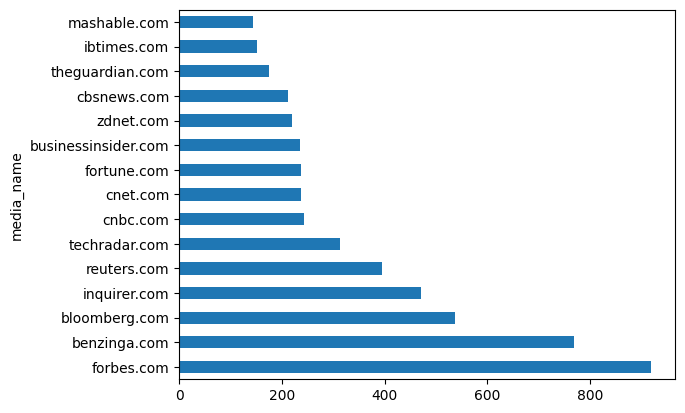

In [45]:
medias = merged_df['media_name'].value_counts().sort_values(ascending=False)[:15]
medias.plot(kind='barh')
plt.show()

### Which topic has the most articles?

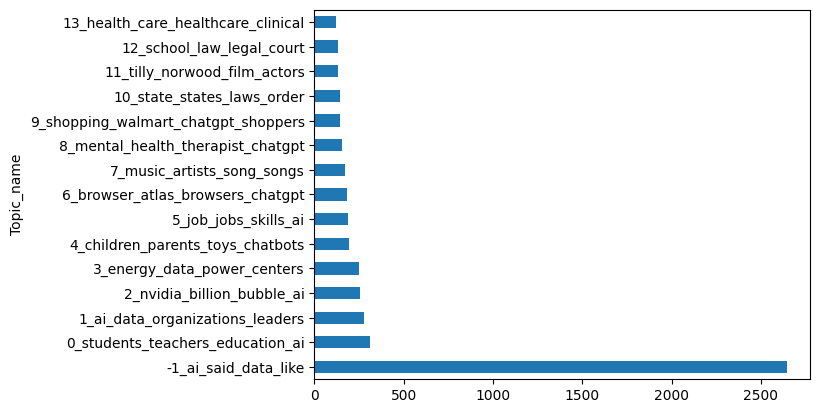

In [46]:
topic_counts = merged_df['Topic_name'].value_counts().sort_values(ascending=False)[:15]
topic_counts.plot(kind="barh")
plt.show()

In [47]:
top_topics = merged_df[merged_df['Topic_name'].isin(topic_counts.index)]

In [48]:
top_topics.shape

(5299, 17)

In [49]:
heatmap_data = (
    top_topics[top_topics["TopicId"] != -1]
      .groupby(["media_name", "Topic_name"])
      .size()
      .unstack(fill_value=0)
)

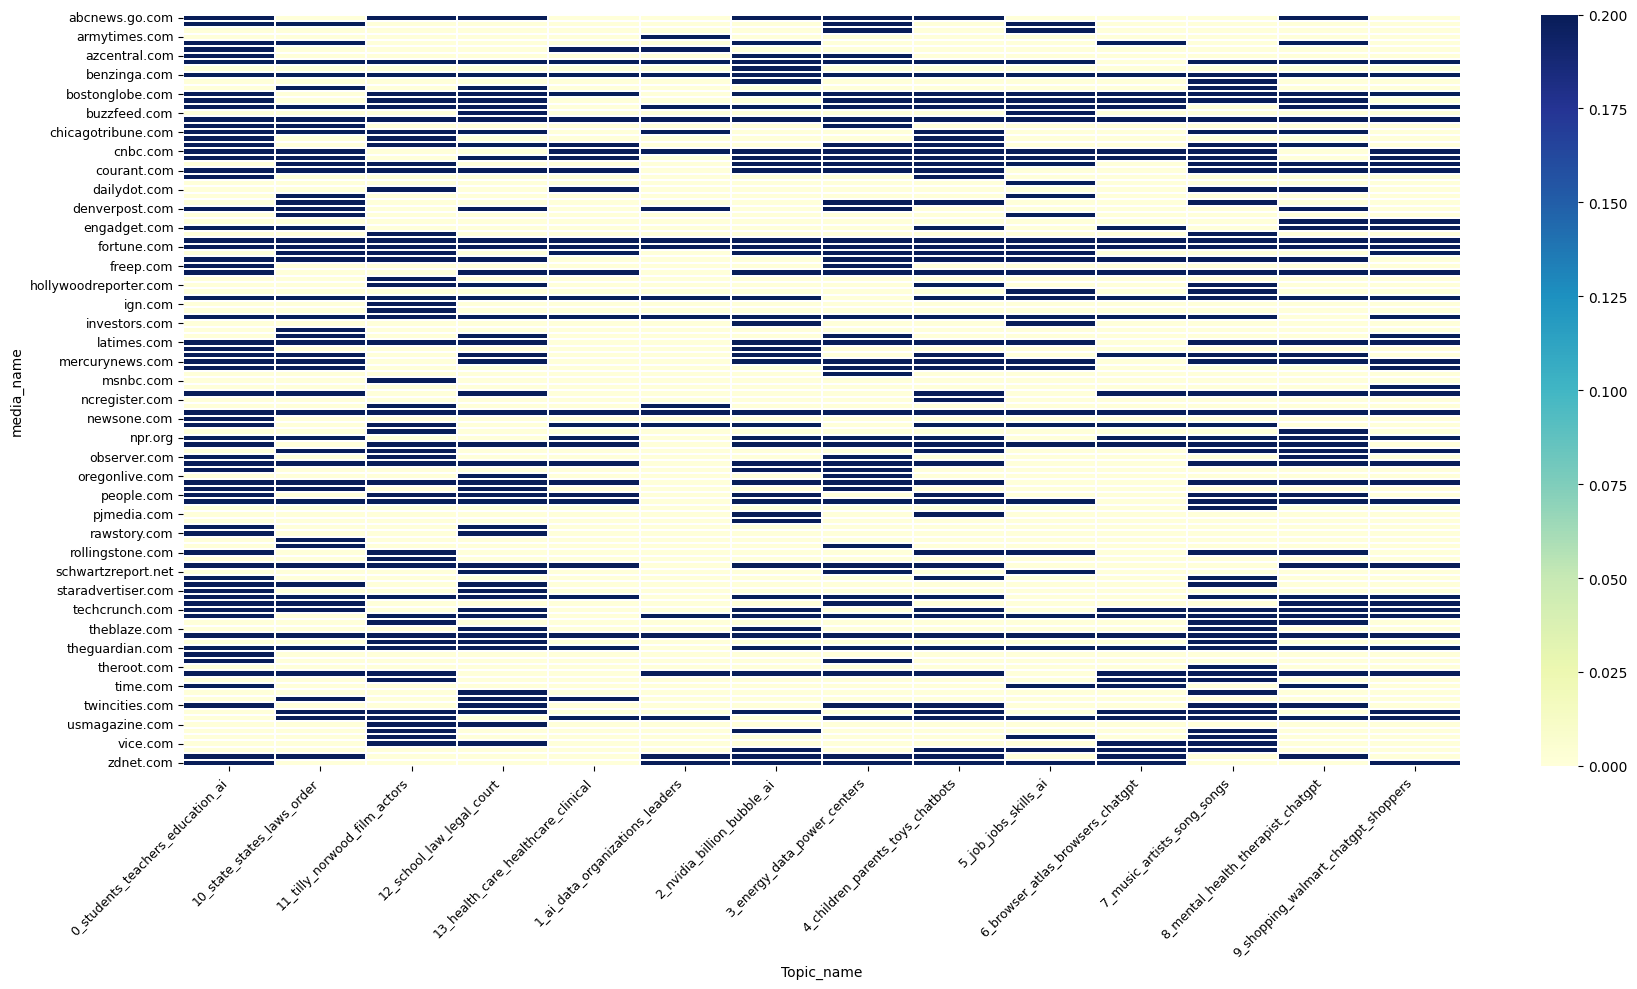

In [50]:
plt.figure(figsize=(18, 10))

sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    vmin=0,
    vmax=0.2,
    linewidths=0.3
)

plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


### What are top media outlets (by count) talking about?

In [51]:
media_counts = merged_df['media_name'].value_counts().sort_values(ascending=False)[:15]
top_medias = merged_df[merged_df['media_name'].isin(media_counts.index)]
heatmap_data = (
    top_medias[top_medias["TopicId"] != -1]
      .groupby(["media_name", "Topic_name"])
      .size()
      .unstack(fill_value=0)
)

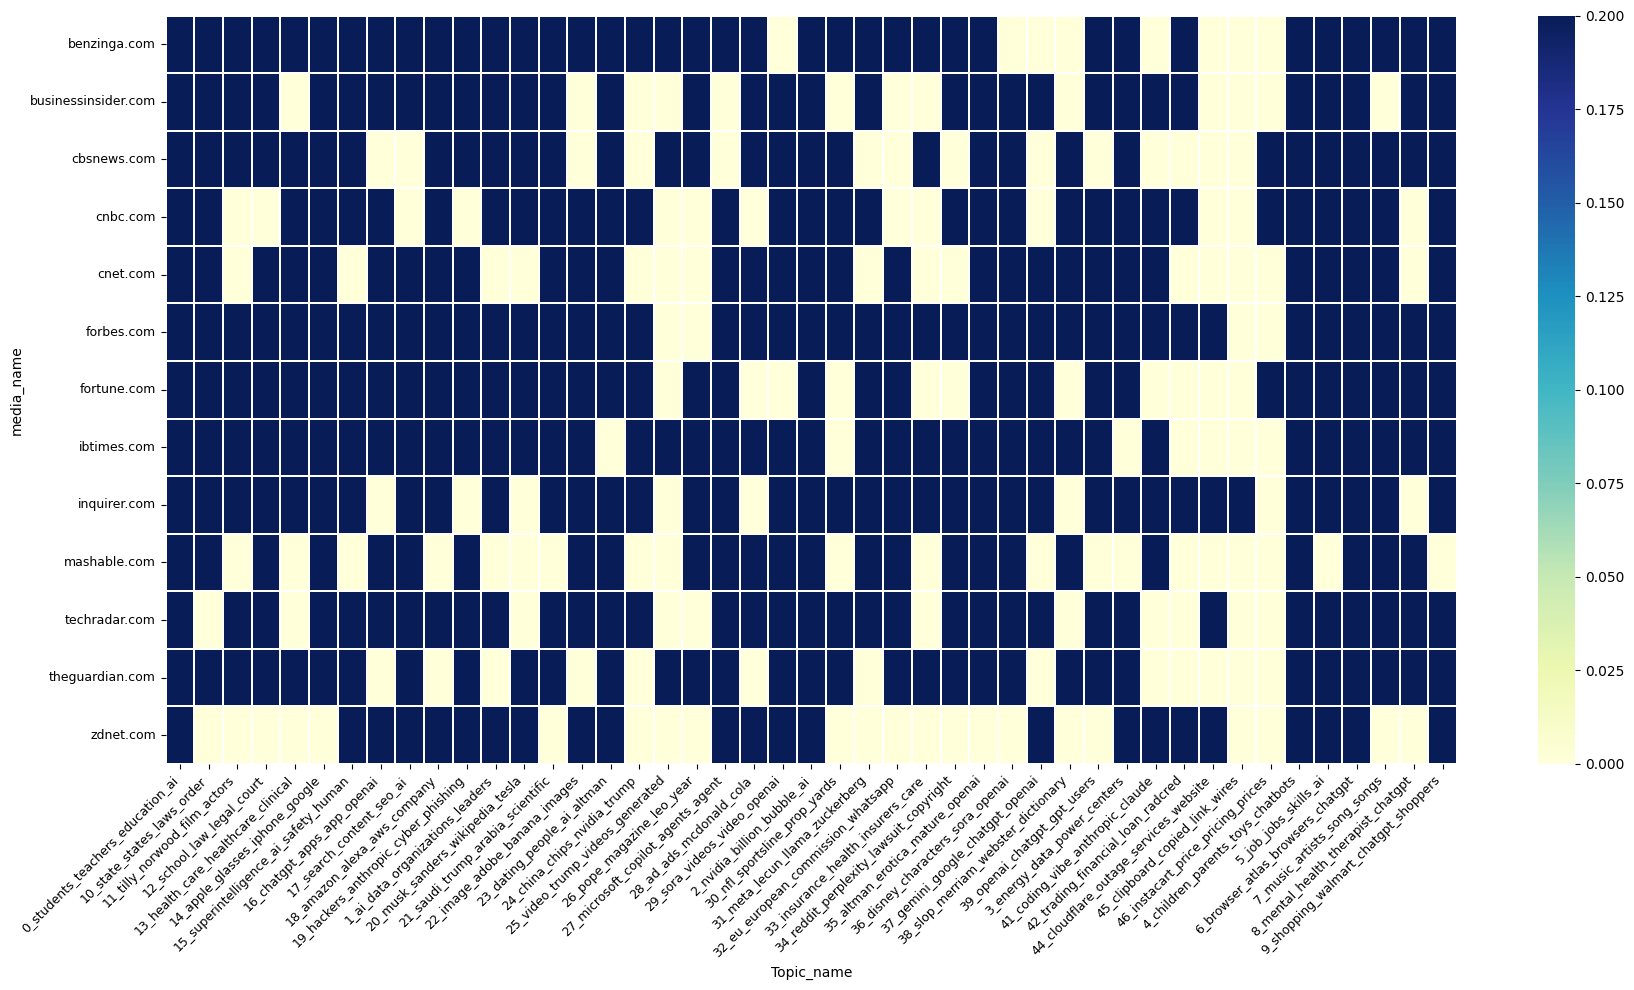

In [52]:
plt.figure(figsize=(18, 10))

sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    vmin=0,
    vmax=0.2,
    linewidths=0.3
)

plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


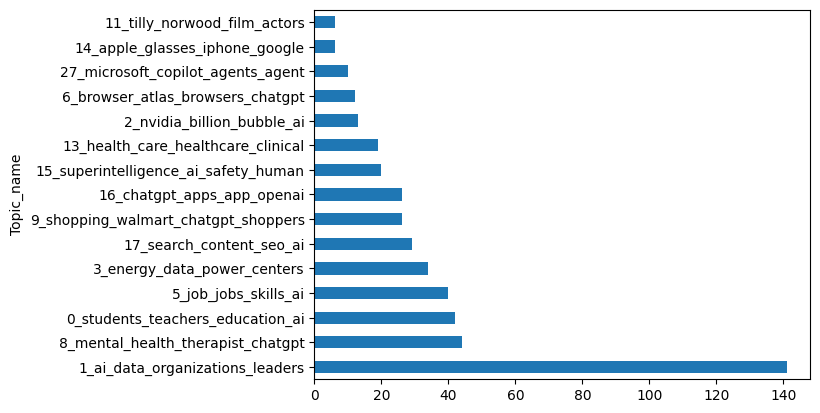

In [53]:
forbes = merged_df[(merged_df['media_name']=='forbes.com') & (merged_df['TopicId'] != -1)]
topic_counts_forbes = forbes['Topic_name'].value_counts().sort_values(ascending=False)[:15]
topic_counts_forbes.plot(kind='barh')
plt.show()

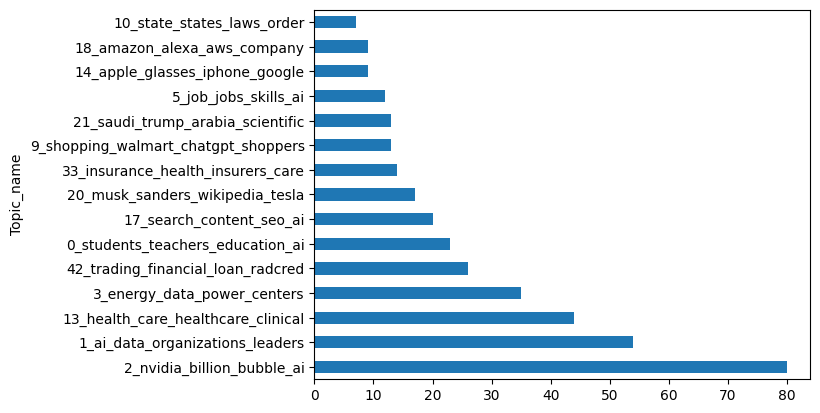

In [54]:
benzinga = merged_df[(merged_df['media_name']=='benzinga.com') & (merged_df['TopicId'] != -1)]
topic_counts_benzinga = benzinga['Topic_name'].value_counts().sort_values(ascending=False)[:15]
topic_counts_benzinga.plot(kind='barh')
plt.show()

### Proportion of top topics in top medias

### Which outlets are more diverse

# Sentiment Analysis

In [105]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="siebert/sentiment-roberta-large-english",
    truncation=True
)

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: siebert/sentiment-roberta-large-english
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [120]:
def chunk_text(text, chunk_size=450):
    try:
        return [
            text[i:i + chunk_size] for i in range(0, len(text), chunk_size)
        ]
    except:
        return []

In [121]:
def article_sentiment(text):
    chunks = chunk_text(text)
    if len(chunks) != 0:
        results = sentiment_pipeline(chunks)
        label_map = {
            "NEGATIVE": -1,
            "POSITIVE": 1
        }

        scores = [
            label_map[r["label"]] * r["score"]
            for r in results
        ]

        return {
            "mean_sentiment": sum(scores) / len(scores),
            "sentiment_variance": float(np.var(scores)),
            "dominant_sentiment": max(
                results,
                key=lambda r: r["score"]
            )["label"]
        }
    else:
        return {}

In [119]:
merged_df['cleaned_text'].isna().sum()

np.int64(1489)

In [122]:
sentiment_results = merged_df["cleaned_text"].apply(article_sentiment)

In [124]:
len(sentiment_results)

8999

In [125]:
sentiment_results

0       {'mean_sentiment': 0.777960459391276, 'sentime...
1       {'mean_sentiment': -0.32563571797476876, 'sent...
2       {'mean_sentiment': -0.19412221227373397, 'sent...
3       {'mean_sentiment': 0.8059408352488563, 'sentim...
4       {'mean_sentiment': -0.9990443587303162, 'senti...
                              ...                        
8994                                                   {}
8995    {'mean_sentiment': 0.9975737716470446, 'sentim...
8996                                                   {}
8997    {'mean_sentiment': 0.1637402574221293, 'sentim...
8998                                                   {}
Name: cleaned_text, Length: 8999, dtype: object

In [126]:
merged_df["sentiment_score"] = sentiment_results.apply(lambda x: x["mean_sentiment"] if isinstance(x, dict) and x else None)
merged_df["sentiment_variance"] = sentiment_results.apply(lambda x: x["sentiment_variance"] if isinstance(x, dict) and x else None)
merged_df["sentiment_label"] = sentiment_results.apply(lambda x: x["dominant_sentiment"] if isinstance(x, dict) and x else "UNKNOWN")

In [127]:
merged_df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title_x,url,error,title_y,text,top_image,images,num_images,cleaned_text,TopicId,Topic_name,sentiment_score,sentiment_variance,sentiment_label
0,19d73b7cd0a23f961ea3aae6d1554c62b004aac1a4a6c7...,2025-12-24 05:22:29.307373+00:00,en,sandiegouniontribune.com,sandiegouniontribune.com,2025-12-23,UC San Diego eyes campuswide AI coordinating s...,https://www.sandiegouniontribune.com/2025/12/2...,NaN,UC San Diego eyes campuswide AI coordinating s...,As institutions across the world establish app...,https://www.sandiegouniontribune.com/wp-conten...,[https://www.sandiegouniontribune.com/wp-conte...,6.0,as institutions across the world establish app...,-1.0,-1_ai_said_data_like,0.777960,0.388300,POSITIVE
1,5dc81d658b56b2424da775f9d2496810172b4e7e907305...,2025-12-24 03:21:38.495827+00:00,en,theweek.com,theweek.com,2025-12-23,Trump vs. states: Who gets to regulate AI?,https://theweek.com/politics/trump-states-regu...,NaN,Trump vs. states: Who gets to regulate AI?,Should technology that’s going to determine Am...,https://cdn.mos.cms.futurecdn.net/FhdL3tZb3YpM...,[https://cdn.mos.cms.futurecdn.net/STkhkAgPdNM...,18.0,should technology that s going to determine am...,-1.0,-1_ai_said_data_like,-0.325636,0.870922,NEGATIVE
2,8424d86c8fb3e91c1ba6ac73b2a9c92fae17bf36871802...,2025-12-24 00:29:59.301749+00:00,en,benzinga.com,benzinga.com,2025-12-23,AI Pioneer Yoshua Bengio Reveals He Misleads C...,https://www.benzinga.com/markets/tech/25/12/49...,NaN,AI Pioneer Yoshua Bengio Reveals He Misleads C...,"Yoshua Bengio, one of the pioneers of artifici...",https://cdn.benzinga.com/files/images/story/20...,[https://www.benzinga.com/_next/image?url=%2Fn...,10.0,yoshua bengio one of the pioneers of artificia...,-1.0,-1_ai_said_data_like,-0.194122,0.868039,NEGATIVE
3,ee34202162eff5335539b80f463a1b20b5f73173155656...,2025-12-24 00:22:34.618199+00:00,en,benzinga.com,benzinga.com,2025-12-23,From Discoverative AI to the Entropy of Tolera...,https://www.benzinga.com/pressreleases/25/12/n...,NaN,From Discoverative AI to the Entropy of Tolera...,"SAN MATEO, Calif. , Dec. 23, 2025 /PRNewswire/...",https://www.benzinga.com/next-assets/images/be...,[https://edge.prnewswire.com/c/img/favicon.png...,14.0,san mateo calif dec prnewswire shanda group ha...,-1.0,-1_ai_said_data_like,0.805941,0.342142,POSITIVE
4,df68b6f39f396d32a2f81a00f381bc30eeb07f72186d82...,2025-12-24 00:19:46.702100+00:00,en,ign.com,ign.com,2025-12-23,"Eddy Burback Made The First Great Horror ""Movi...",https://www.ign.com/videos/eddy-burback-made-t...,NaN,"Eddy Burback Made The First Great Horror ""Movi...",0:23\n\n28 Years Later Star Wants to Be in a D...,https://assets-prd.ignimgs.com/2025/12/20/eddy...,[https://assets-prd.ignimgs.com/2025/12/20/edd...,2.0,years later star wants to be in a dead space m...,-1.0,-1_ai_said_data_like,-0.999044,0.000000,NEGATIVE


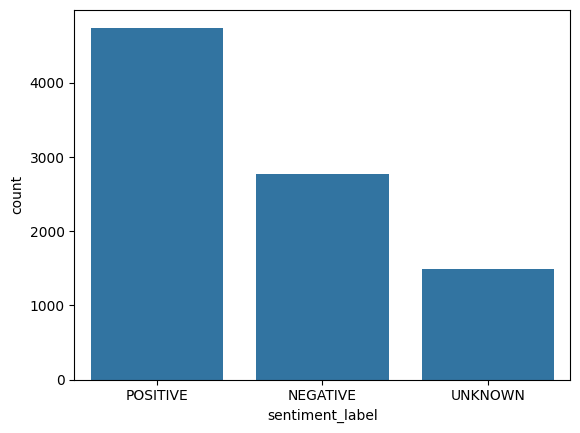

In [130]:
sentiment_count = merged_df['sentiment_label'].value_counts()
sns.barplot(x=sentiment_count.index, y=sentiment_count)
plt.show()

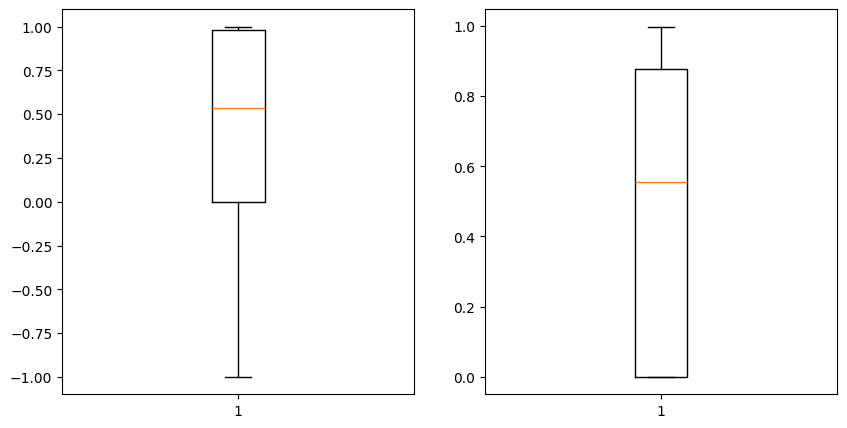

In [138]:
sentiment_scores = merged_df['sentiment_score'].dropna()
sentiment_vars = merged_df['sentiment_variance'].dropna()

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].boxplot(sentiment_scores)
ax[1].boxplot(sentiment_vars)
plt.show()


In [172]:
merged_df['Topic_name'].value_counts().shape

(48,)

In [139]:
merged_df['sentiment_variance'].describe()

count    7509.000000
mean        0.501975
std         0.379575
min         0.000000
25%         0.000025
50%         0.556036
75%         0.877650
max         0.997690
Name: sentiment_variance, dtype: float64

In [140]:
merged_df.to_csv('withSentiment.csv')

In [169]:
negative = merged_df[merged_df['sentiment_label'] == "NEGATIVE"]
negative.shape

(2765, 20)

In [177]:
positive = merged_df[merged_df['sentiment_label'] == "POSITIVE"]
positive.shape

(4744, 20)

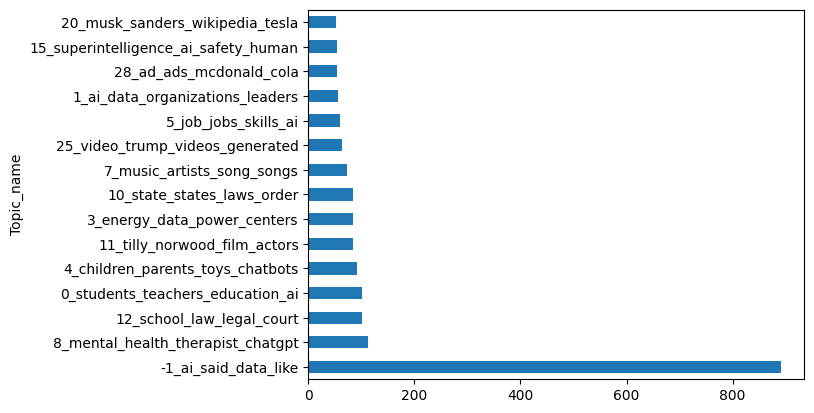

In [176]:
negative_topics = negative['Topic_name'].value_counts().sort_values(ascending=False)[:15]
negative_topics.plot(kind='barh')
plt.show()

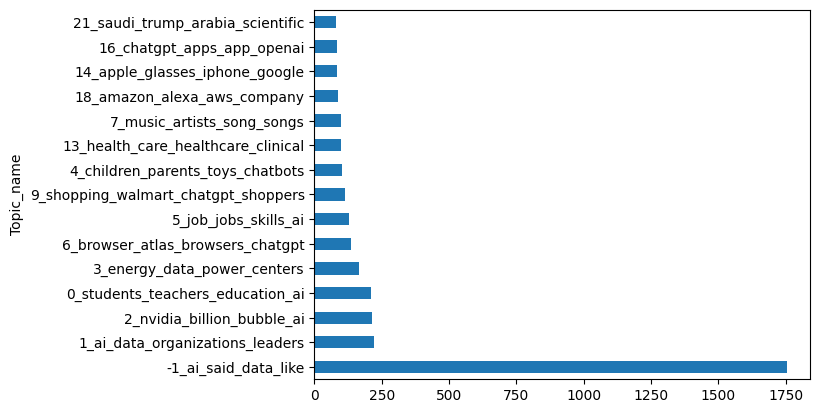

In [178]:
positive_topics = positive['Topic_name'].value_counts().sort_values(ascending=False)[:15]
positive_topics.plot(kind='barh')
plt.show()

In [179]:
pd.crosstab(
    [merged_df["media_name"], merged_df["TopicId"]],
    merged_df["sentiment_label"],
    normalize="index"
)

sentiment_label         NEGATIVE  POSITIVE  UNKNOWN
media_name     TopicId                             
abcnews.go.com -1.0     1.000000  0.000000      0.0
                0.0     0.000000  1.000000      0.0
                2.0     0.500000  0.500000      0.0
                3.0     0.000000  1.000000      0.0
                4.0     1.000000  0.000000      0.0
...                          ...       ...      ...
zdnet.com       29.0    0.666667  0.333333      0.0
                37.0    0.041667  0.958333      0.0
                41.0    0.000000  1.000000      0.0
                42.0    0.000000  1.000000      0.0
                44.0    1.000000  0.000000      0.0

[1671 rows x 3 columns]

In [180]:
import scipy.stats as stats

In [181]:
def calculate_entropy(labels):
    probs = labels.value_counts(normalize=True)
    return stats.entropy(probs)

In [185]:
topic_entropy = (
    merged_df
    .groupby("Topic_name")["sentiment_label"]
    .apply(calculate_entropy)
    .reset_index(name="sentiment_entropy")
)

In [188]:
topic_entropy["sentiment_entropy"] = (
    topic_entropy["sentiment_entropy"] / np.log(2)
)

In [189]:
topic_entropy.head()

,Topic_name,sentiment_entropy
0,-1_ai_said_data_like,0.921784
1,0_students_teachers_education_ai,0.911752
2,10_state_states_laws_order,0.975680
3,11_tilly_norwood_film_actors,0.941665
4,12_school_law_legal_court,0.751650


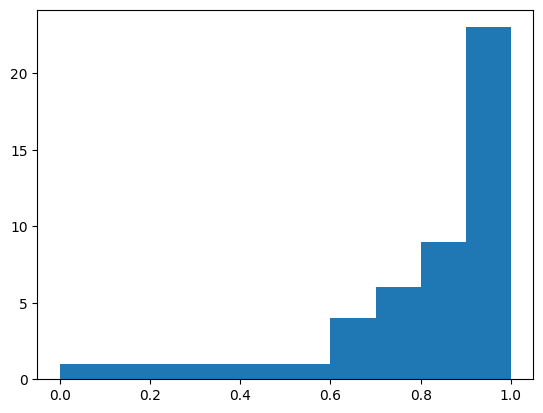

In [190]:
plt.hist(topic_entropy['sentiment_entropy'])
plt.show()

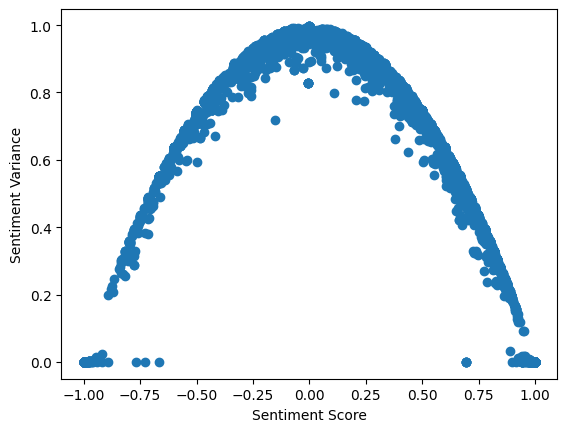

In [142]:
plt.scatter(merged_df['sentiment_score'], merged_df['sentiment_variance'])
plt.xlabel("Sentiment Score")
plt.ylabel("Sentiment Variance")
plt.show()

In [147]:
topic_sentiment_agg = merged_df.groupby("TopicId").agg(
    topic_sentiment_mean=("sentiment_score", "mean"),
    topic_sentiment_var=("sentiment_variance", "mean"),
    article_count=("sentiment_score", "count")
).reset_index()

In [148]:
topic_sentiment_agg.head()

,TopicId,topic_sentiment_mean,topic_sentiment_var,article_count
0,-1.0,0.443744,0.481577,2645
1,0.0,0.551517,0.458837,312
2,1.0,0.713529,0.360114,275
3,2.0,0.655582,0.397015,257
4,3.0,0.462424,0.524533,250


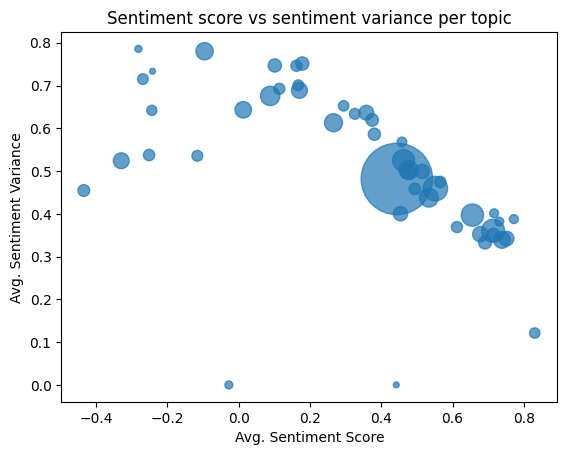

In [164]:
plt.scatter(topic_sentiment_agg['topic_sentiment_mean'], 
                topic_sentiment_agg['topic_sentiment_var'], 
                s=topic_sentiment_agg['article_count'],
                alpha=0.7)
plt.xlabel("Avg. Sentiment Score")
plt.ylabel("Avg. Sentiment Variance")
plt.title("Sentiment score vs sentiment variance per topic")
plt.show()


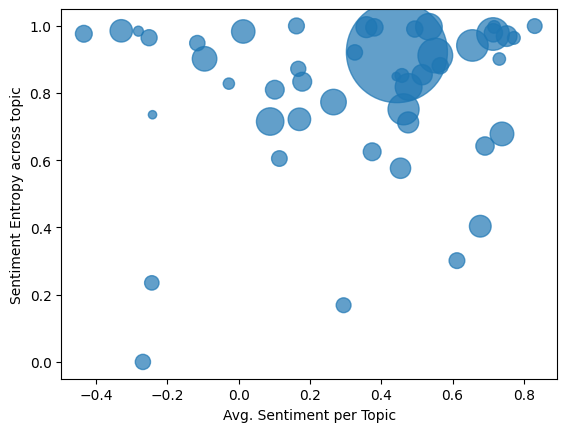

In [192]:
plt.scatter(
    topic_sentiment_agg['topic_sentiment_mean'], 
    topic_entropy['sentiment_entropy'],
    s=topic_sentiment_agg["article_count"] * 2,
    alpha=0.7
)
plt.ylabel("Sentiment Entropy across topic")
plt.xlabel("Avg. Sentiment per Topic")
plt.show()

Most topics have high entropy across all sentiments

In [195]:
topic_sentiment_prop = merged_df.groupby(['TopicId', 'sentiment_label']).size().unstack(fill_value=0)
topic_sentiment_prop = topic_sentiment_prop.div(topic_sentiment_prop.sum(axis=1),axis=0)

In [197]:
topic_sentiment_prop.head()

sentiment_label,NEGATIVE,POSITIVE,UNKNOWN
TopicId,,,
-1.0,0.336862,0.663138,0.0
0.0,0.326923,0.673077,0.0
1.0,0.200000,0.800000,0.0
2.0,0.163424,0.836576,0.0
3.0,0.336000,0.664000,0.0


# Outlier data

In [68]:
outliers = merged_df[merged_df['TopicId'] == -1]

In [69]:
outliers.shape

(2645, 17)

In [70]:
from wordcloud import WordCloud

In [71]:
outlier_text = " ".join(outliers['cleaned_text'])

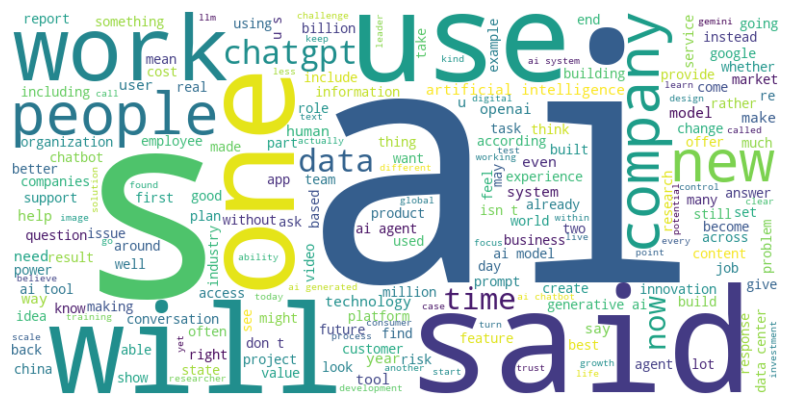

In [72]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(outlier_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Turn off axis lines and labels
plt.show()

In [73]:
vectorizer_model = CountVectorizer(stop_words="english")

In [74]:
outlier_bert = BERTopic(
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

In [75]:
outlier_texts = outliers['cleaned_text'].astype(str).to_list()

In [76]:
outlier_topics, outlier_probabs = outlier_bert.fit_transform(outlier_texts)

2026-02-06 13:20:15,730 - BERTopic - Embedding - Transforming documents to embeddings.


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/83 [00:00<?, ?it/s]

2026-02-06 13:20:31,578 - BERTopic - Embedding - Completed ✓
2026-02-06 13:20:31,579 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-06 13:20:34,841 - BERTopic - Dimensionality - Completed ✓
2026-02-06 13:20:34,842 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-06 13:20:35,083 - BERTopic - Cluster - Completed ✓
2026-02-06 13:20:35,085 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-06 13:20:35,595 - BERTopic - Representation - Completed ✓


In [77]:
outlier_topic_info = outlier_bert.get_topic_info()
outlier_topic_info.shape

(71, 5)

In [78]:
outlier_bert.visualize_barchart()

In [79]:
outlier_bert.visualize_hierarchy()

# Data Exctraction Script

In [80]:
# def text_cleaning(text):
#   text = text.lower()
#   text = re.sub(r'http\S+|www\S+', '', text)
#   text = re.sub(r'<.*?>', '', text)
#   text = emoji.replace_emoji(text, replace='')
#   text = re.sub(r"[^a-z\s']", ' ', text)
#   text = re.sub(r'\s+', ' ', text).strip()
#   return text
# ai_df['cleaned_title'] = ai_df['title'].apply(text_cleaning)

In [81]:
# df1 = ai_df[5000:]
# df1.shape

In [82]:
# def get_src_alt(images):
#   try:
#     html_strs = [str(image) for image in images]
#     result = []
#     for html_str in html_strs:
#       if html_str != "" :
#         match_str_src = re.search(r'\bsrc="([^"]+)"', html_str)
#         match_str_alt = re.search(r'\balt="([^"]+)"', html_str)
#         obj = {'src':(match_str_src.group(1) if match_str_src else ""),'alt':(match_str_alt.group(1) if match_str_alt else "")}
#         result.append(obj)
#       else:
#         continue
#     return result
#   except:
#     return []

# def get_next_text(images):
#   result = []
#   allowed_tags = ['figcaption', 'span', 'p']
#   if images != "":
#     for img in images:
#       text = img.find_next(allowed_tags)
#       if text:
#         text = text.get_text(strip=True)
#       else:
#         text = " "
#       result.append(text)
#     return result
#   else:
#     return ""

# def get_images(soup):
#   try:
#     images = soup.find_all('img')
#     return images
#   except:
#     return ""

# def get_article_text(soup):
#   try:
#     return soup.get_text(strip = True)
#   except:
#     return ""

In [83]:
# headers = {"User-Agent": "Mozilla/5.0"}
# response = requests.get(url_sample, headers=headers, timeout=10)
# soup = BeautifulSoup(response.text, "html.parser")

In [84]:
# get_article_text(soup)

In [85]:
# !pip install newspaper3k

In [86]:
# !pip install lxml_html_clean

In [87]:
# from newspaper import Article

In [88]:
# article = Article(url_sample)
# article.download()
# article.parse()

# print(article.text)


In [89]:
# article.images

In [90]:
# from newspaper import Article, Config
# import requests
# import os

# config = Config()
# config.browser_user_agent = "Mozilla/5.0"
# config.fetch_images = True
# config.memoize_articles = False  # important for scale

# def scrape_article(url):
#     try:
#         article = Article(url, config=config)
#         article.download()
#         article.parse()

#         return {
#             "url": url,
#             "title": article.title,
#             "text": article.text,
#             "top_image": article.top_image,
#             "images": list(article.images)
#         }

#     except Exception as e:
#         return {
#             "url": url,
#             "error": str(e)
#         }


In [91]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm

# def scrape_bulk(urls, max_workers=24):
#     results = []

#     with ThreadPoolExecutor(max_workers=max_workers) as executor:
#         futures = [executor.submit(scrape_article, url) for url in urls]

#         for future in tqdm(as_completed(futures), total=len(futures)):
#             results.append(future.result())

#     return results

In [92]:
# article_urls = ai_df['url']

In [93]:
# results = scrape_bulk(article_urls, max_workers=24)

In [94]:
# article_df = pd.DataFrame(results)

In [95]:
# success_df = article_df[article_df["error"].isna()]
# failed_df = article_df[article_df["error"].notna()]

In [96]:
# success_df["num_images"] = success_df["images"].apply(
#     lambda x: len(x) if isinstance(x, list) else 0
# )

In [97]:
# images_df = (
#     success_df
#     .explode("images")
#     .rename(columns={"images": "image_url"})
#     .dropna(subset=["image_url"])
# )


In [98]:
# success_df.info()

In [99]:
# success_df.head(1)

In [100]:
# success_df['text'][4]

In [101]:
# success_df.to_json("articles.jsonl", orient="records", lines=True)

In [102]:
# urls = df1['url']
# result = await fetch_all(urls)
# url, soup = zip(*result)
# result_df = pd.DataFrame({"url":url, "soup":soup})
# result_df.shape

In [103]:
# df1 = pd.merge(df1, result_df, on='url')
# df1['images'] = df1['soup'].apply(get_images)
# df1['caption'] = df1['images'].apply(get_next_text)
# df1['src_alt'] = df1['images'].apply(get_src_alt)
# df1['text'] = df1['soup'].apply(get_article_text)

In [104]:
# !mkdir articles
# import os

# path = "/content/articles"
# os.makedirs(path, exist_ok=True)

# for article_id, article_text in zip(df1["id"], df1["text"]):
#     file_path = os.path.join(path, f"{article_id}.txt")
#     with open(file_path, "w", encoding="utf-8") as f:
#         f.write(str(article_text))